In [1]:
import pandas as pd
import numpy as np
import uuid
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
sns.set_style("ticks")

Olist conducted an experiment to see if altering the delivery estimation could result in higher review scores.

# Generate random data for A/B testing

In [2]:
date_range = pd.date_range(start="2018-07-01", end="2018-09-01")

In [3]:
date_range

DatetimeIndex(['2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04',
               '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08',
               '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12',
               '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16',
               '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20',
               '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24',
               '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28',
               '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01',
               '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05',
               '2018-08-06', '2018-08-07', '2018-08-08', '2018-08-09',
               '2018-08-10', '2018-08-11', '2018-08-12', '2018-08-13',
               '2018-08-14', '2018-08-15', '2018-08-16', '2018-08-17',
               '2018-08-18', '2018-08-19', '2018-08-20', '2018-08-21',
               '2018-08-22', '2018-08-23', '2018-08-24', '2018-08-25',
      

In [4]:
np.datetime64("2018-07-15")

numpy.datetime64('2018-07-15')

In [5]:
control = {1: 10,
           2: 3,
           3: 8,
           4: 20,
           5: 59}

test = {1: 10,
        2: 2,
        3: 10,
        4: 22,
        5: 63}

def generate_review_distribution(freq_dict):
    l = []
    for key, value in freq_dict.items():
        l += [key] * value
    return l

In [6]:
def get_random_review(date, group):
    if (group == 102) & (date >= np.datetime64("2018-07-15")):
        random_reviews = generate_review_distribution(test)
    else:
        random_reviews = generate_review_distribution(control)
    return random.choice(random_reviews)
    
def generate_random_observation(date, group):
    return str(uuid.uuid4()), get_random_review(date, group)

In [7]:
# create list of dicts to later on convert to a dataframe
rows = []
for date in date_range:
    # two groups
    for group in [101,102]:
        # pick a random number of orders btw 350 and 450
        orders = random.choice(range(350,450))
        for obs in range(orders):
            order_id, review_score = generate_random_observation(date, group)
            rows.append({"date_id": date,
                         "experiment_id": group,
                         "order_id": order_id,
                         "review_score": review_score})
            
df = pd.DataFrame(rows)

In [8]:
df

,date_id,experiment_id,order_id,review_score
0,2018-07-01,101,04a383ea-26c9-4015-8b6b-1ee25e11bd64,5
1,2018-07-01,101,9dcf93db-1dde-4873-a88d-c461ddbb7fff,4
2,2018-07-01,101,615b1654-a1b6-4ee2-93b8-1bdd14f72939,5
3,2018-07-01,101,b701be35-505b-4ac4-a98a-f5e48643da0b,1
4,2018-07-01,101,80c07215-ec76-404f-bc84-70abaa2ee2c3,3
...,...,...,...,...
50636,2018-09-01,102,4f6b55cb-0514-4f23-9dc8-b44dcf351c23,4
50637,2018-09-01,102,0e6a93f2-502e-4a10-a358-632755c48f21,4
50638,2018-09-01,102,8ad8ab40-72ff-4567-9b1c-91438e612785,4
50639,2018-09-01,102,80d3f60a-b035-4977-b5c5-f97571bdf44a,1


### Plot data and calculate means

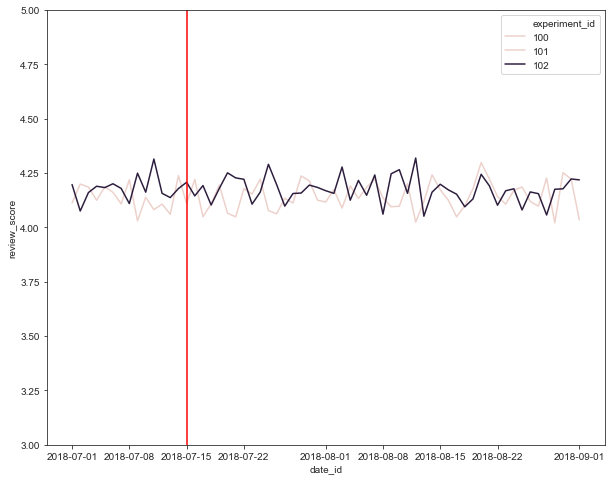

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
sns.lineplot(data=df.groupby(["date_id", "experiment_id"]).mean().reset_index(),
             x="date_id",
             y="review_score",
             hue="experiment_id",
             ax=ax);
ax.axvline("2018-07-15", color="r")
ax.set_ylim(3,5);

In [10]:
df[df["date_id"] > "2018-07-15"].groupby("experiment_id").mean()

,review_score
experiment_id,
101,4.144716
102,4.174121


In [11]:
df.to_csv("olist_experiment_data.csv")

How do we know if this difference did not just occure by chance?
We have uncertainty because we are looking at a sample and want to generalize to all users.


We use statistics => t-test

# Central Limit Theorem

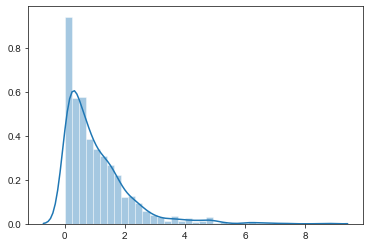

In [12]:
sns.distplot(np.random.exponential(size=1000));

In [13]:
means = []
for i in range(1000):
    means.append(np.random.exponential(size=1000).mean())

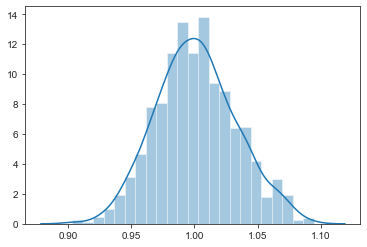

In [14]:
sns.distplot(means);

Create a function that allows us to tweak the parameters and use different distributions

In [15]:
def plot_clt(sample_size, repetition, distr):
    sample_means = [distr(size=sample_size).mean() for i in range(repetition)]
    sns.distplot(sample_means, color="r")

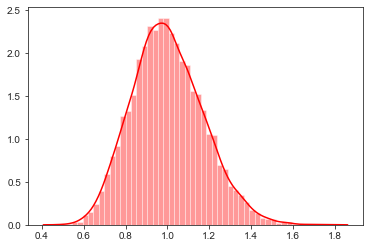

In [16]:
plot_clt(35, 10000, np.random.exponential)

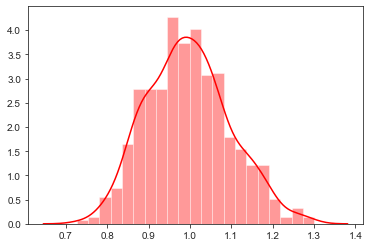

In [17]:
plot_clt(100, 1000, np.random.exponential)

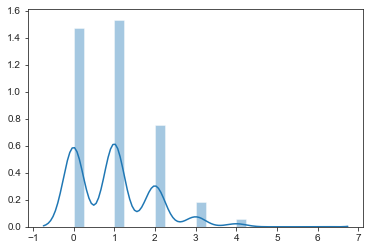

In [18]:
sns.distplot(np.random.poisson(size=1000));

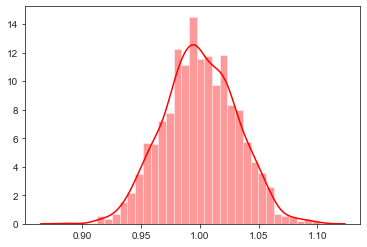

In [19]:
plot_clt(1000, 2000, np.random.poisson)

In [20]:
# alter function so I can layer multiple plots on the same graph
def plot_clt(sample_size, repetition, distr, ax=None, color=None):
    sample_means = [distr(size=sample_size).mean() for i in range(repetition)]
    sns.distplot(sample_means, color=color, ax=ax)

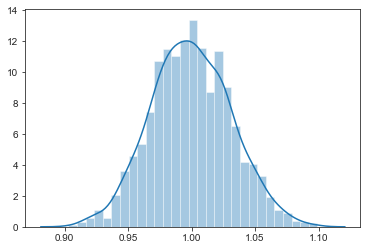

In [21]:
plot_clt(1000, 2000, np.random.poisson)

test the functions

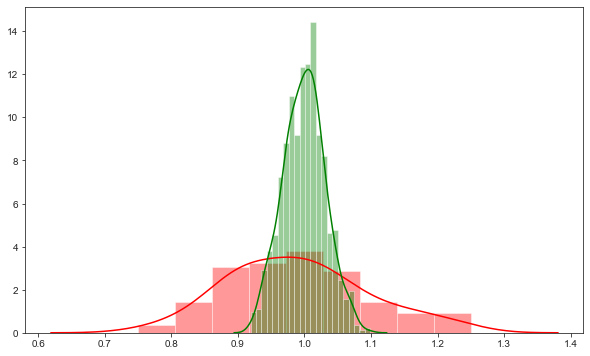

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
plot_clt(100,100,np.random.poisson,ax,"r")
plot_clt(1000,1000,np.random.poisson,ax,"g")

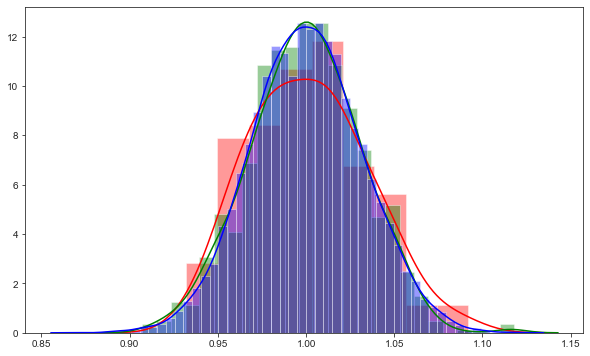

In [23]:
# alter repetitions, keep sample_size
fig, ax = plt.subplots(figsize=(10,6))
plot_clt(1000,100,np.random.poisson,ax,"r")
plot_clt(1000,1000,np.random.poisson,ax,"g")
plot_clt(1000,10000,np.random.poisson,ax,"b")

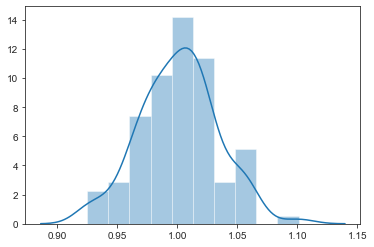

In [24]:
plot_clt(1000,100,np.random.poisson)

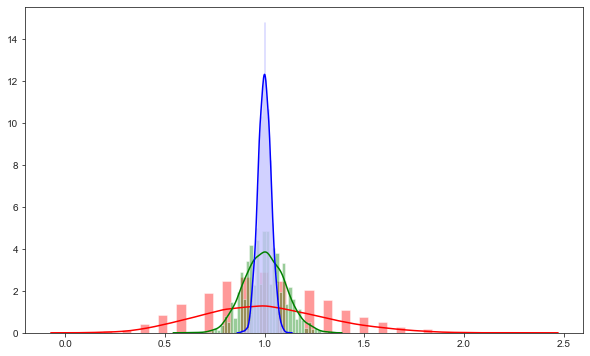

In [25]:
# keep repetitions, alter sample_size
fig, ax = plt.subplots(figsize=(10,6))
plot_clt(10,5000,np.random.poisson,ax,"r")
plot_clt(100,5000,np.random.poisson,ax,"g")
plot_clt(1000,5000,np.random.poisson,ax,"b")

# Run that t-test

Testing the hypothesis that our newly introduced change had no effect. 

Nullhypothesis:

$H_0: avg\_rating_{control} = avg\_rating_{test}$

$ <=> avg\_rating_{control} - avg\_rating_{test} = 0$

Against the alternative hypothesis:

$H_1: avg\_rating_{control} \neq avg\_rating_{test}$

In [26]:
df.dtypes

date_id          datetime64[ns]
experiment_id             int64
order_id                 object
review_score              int64
dtype: object

In [27]:
# we only started the experiment on 2018-07-15
df = df[df["date_id"].gt("2018-07-14")]
df.head()

,date_id,experiment_id,order_id,review_score
11044,2018-07-15,101,6aba2d77-ac80-4214-8668-f58314e77895,2
11045,2018-07-15,101,32c06ad1-4029-4abb-bf6a-5aa86025a56a,5
11046,2018-07-15,101,04e25dee-c06e-47a7-bcf0-5d8b60c02d27,5
11047,2018-07-15,101,7807c847-b575-43f3-b462-9a3a540a0f70,3
11048,2018-07-15,101,6b0cf8a8-9e87-4097-aacd-249587d67f4a,5


In [28]:
# get the means
means = (df
         .groupby("experiment_id")
         .agg({"review_score": "mean"})
         .rename(columns={"review_score": "avg_review_score"}))
means

,avg_review_score
experiment_id,
101,4.143935
102,4.174859


In [29]:
var = (df
       .groupby("experiment_id")
       .agg({"review_score": "var"})
       .rename(columns={"review_score": "review_score_var"}))
var

,review_score_var
experiment_id,
101,1.675907
102,1.565963


In [30]:
stds = (df
        .groupby("experiment_id")
        .agg({"review_score": "std"})
        .rename(columns={"review_score": "review_score_std"}))
stds

,review_score_std
experiment_id,
101,1.294568
102,1.251384


In [31]:
ssizes = (df
          .groupby("experiment_id")
          .agg({"review_score": "count"})
          .rename(columns={"review_score": "sample_size"}))
ssizes

,sample_size
experiment_id,
101,19884
102,19713


Plot the distribution of the sample mean

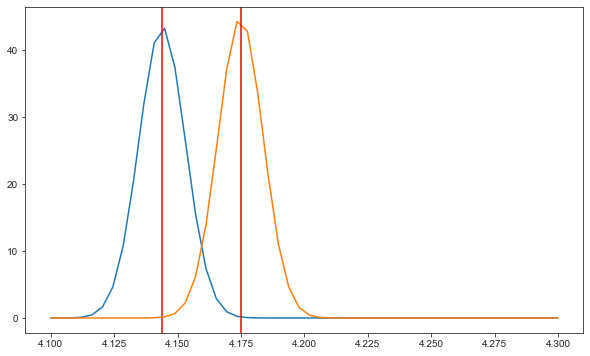

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
# control
# calculate the standard error
se_c = stds.loc[101,"review_score_std"] / np.sqrt(ssizes.loc[101,"sample_size"])
pdf_c = scipy.stats.norm.pdf(np.linspace(4.1,4.3),
                             means.loc[101,"avg_review_score"],
                             se_c)
plt.plot(np.linspace(4.1,4.3), pdf_c);
ax.axvline(means.loc[101,"avg_review_score"], color="r");

# test
se_t = stds.loc[102,"review_score_std"] / np.sqrt(ssizes.loc[102,"sample_size"])
pdf_t = scipy.stats.norm.pdf(np.linspace(4.1,4.3),
                             means.loc[102,"avg_review_score"],
                             se_t)
plt.plot(np.linspace(4.1,4.3), pdf_t);
ax.axvline(means.loc[102,"avg_review_score"], color="r");

In [33]:
combined_standard_error = np.sqrt(var.loc[101,"review_score_var"]/ssizes.loc[101,"sample_size"] + var.loc[102,"review_score_var"]/ssizes.loc[102,"sample_size"])
diff_mean = means.loc[101,"avg_review_score"] - means.loc[102,"avg_review_score"]

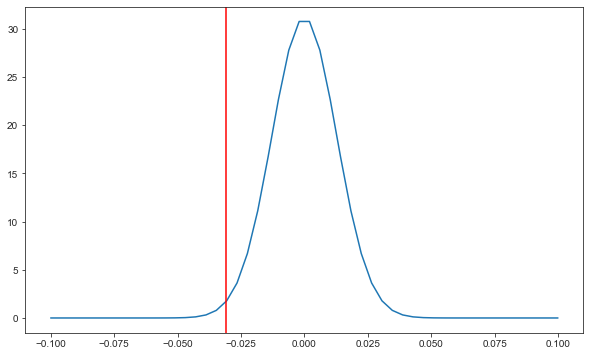

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.linspace(-.1,.1)
pdf = scipy.stats.norm.pdf(x,
                           0,
                           combined_standard_error)
plt.plot(x, pdf);
ax.axvline(diff_mean, color="r");

In [35]:
t = diff_mean / combined_standard_error
t

-2.4168378019583567

In [36]:
scipy.stats.ttest_ind(df.loc[df["experiment_id"].eq(101),"review_score"],
                      df.loc[df["experiment_id"].eq(102),"review_score"],
                      equal_var=False)

Ttest_indResult(statistic=-2.4168378019583563, pvalue=0.01566048471221509)

### Inference
Applying an alpha level of 5%, we reject the null hypothesis that the mean of both samples are equal. Hence, we conclude that the change we introduced has had a statistically significant impact on the average `review_score`. The effect size is estimated to be approximately 0.03, resulting in an increase of average review scores from 4.14 to 4.17.

### Interpreting the p-value
Given our sample, assuming the null hypothesis, the likelihood of obtaining the difference we observed or more extreme is 0.8%.

**Generally**:

Given the data, assuming the null hypothesis is true, how likely is it that we obtain the value we observed or more extreme.

## Plot convergence

In [37]:
df_exp = df.loc[df["date_id"].ge("2018-07-15")].copy()
df_exp

,date_id,experiment_id,order_id,review_score
11044,2018-07-15,101,6aba2d77-ac80-4214-8668-f58314e77895,2
11045,2018-07-15,101,32c06ad1-4029-4abb-bf6a-5aa86025a56a,5
11046,2018-07-15,101,04e25dee-c06e-47a7-bcf0-5d8b60c02d27,5
11047,2018-07-15,101,7807c847-b575-43f3-b462-9a3a540a0f70,3
11048,2018-07-15,101,6b0cf8a8-9e87-4097-aacd-249587d67f4a,5
...,...,...,...,...
50636,2018-09-01,102,4f6b55cb-0514-4f23-9dc8-b44dcf351c23,4
50637,2018-09-01,102,0e6a93f2-502e-4a10-a358-632755c48f21,4
50638,2018-09-01,102,8ad8ab40-72ff-4567-9b1c-91438e612785,4
50639,2018-09-01,102,80d3f60a-b035-4977-b5c5-f97571bdf44a,1


Start with first day

In [38]:
sample_date = "2018-07-16"
# for any given date, fetch the rows from df_exp up until that date
s_df = df_exp[df_exp["date_id"].le(sample_date)]

# compute all required statistics
s_stats = s_df.groupby("experiment_id").agg({"review_score": ["mean", "var", "std", "count"]})
s_diff_mean = s_stats.loc[101,"review_score"]["mean"] - s_stats.loc[102,"review_score"]["mean"]
s_cse = np.sqrt(s_stats.loc[101,"review_score"]["var"]/s_stats.loc[101,"review_score"]["count"] + s_stats.loc[102,"review_score"]["var"]/s_stats.loc[102,"review_score"]["count"])

# run t-test
s_test = scipy.stats.ttest_ind(s_df[s_df["experiment_id"].eq(101)]["review_score"],
                               s_df[s_df["experiment_id"].eq(102)]["review_score"],
                               equal_var=False)

s_t = s_test.statistic
s_p = s_test.pvalue

row = {"date_id": sample_date,
       "diff_mean": s_diff_mean,
       "se": s_cse,
       "lc": s_diff_mean - (1.96 * s_cse),
       "uc": s_diff_mean + (1.96 * s_cse),
       "t-statistic": s_t,
       "p-value": s_p}

In [39]:
pd.DataFrame([row])

,date_id,diff_mean,se,lc,uc,t-statistic,p-value
0,2018-07-16,-0.010778,0.059232,-0.126872,0.105316,-0.181964,0.855632


In [40]:
def generate_cum_test_results(df, date):
    df_cum = df[df["date_id"].le(date)]
    
    # compute all required statistics
    stats = df_cum.groupby("experiment_id").agg({"review_score": ["mean", "var", "std", "count"]})
    diff_mean = stats.loc[102,"review_score"]["mean"] - stats.loc[101,"review_score"]["mean"]
    cse = np.sqrt(stats.loc[101,"review_score"]["var"]/stats.loc[101,"review_score"]["count"] + stats.loc[102,"review_score"]["var"]/stats.loc[102,"review_score"]["count"])
    
    # run t-test
    test = scipy.stats.ttest_ind(df_cum[df_cum["experiment_id"].eq(101)]["review_score"],
                                 df_cum[df_cum["experiment_id"].eq(102)]["review_score"],
                                 equal_var=False)
    
    t = test.statistic
    p = test.pvalue
    
    return {"date_id": date,
            "diff_mean": diff_mean,
            "se": cse,
            "lc": diff_mean - (1.96 * cse),
            "uc": diff_mean + (1.96 * cse),
            "t-statistic": t,
            "p-value": p}

In [41]:
pd.DataFrame([generate_cum_test_results(df_exp, sample_date)])

,date_id,diff_mean,se,lc,uc,t-statistic,p-value
0,2018-07-16,0.010778,0.059232,-0.105316,0.126872,-0.181964,0.855632


In [42]:
pd.date_range(start="2018-07-15", end="2018-09-01")

DatetimeIndex(['2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18',
               '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22',
               '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26',
               '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30',
               '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03',
               '2018-08-04', '2018-08-05', '2018-08-06', '2018-08-07',
               '2018-08-08', '2018-08-09', '2018-08-10', '2018-08-11',
               '2018-08-12', '2018-08-13', '2018-08-14', '2018-08-15',
               '2018-08-16', '2018-08-17', '2018-08-18', '2018-08-19',
               '2018-08-20', '2018-08-21', '2018-08-22', '2018-08-23',
               '2018-08-24', '2018-08-25', '2018-08-26', '2018-08-27',
               '2018-08-28', '2018-08-29', '2018-08-30', '2018-08-31',
               '2018-09-01'],
              dtype='datetime64[ns]', freq='D')

In [43]:
df_cum_exp = pd.DataFrame([generate_cum_test_results(df_exp, date) for date in pd.date_range(start="2018-07-15", end="2018-09-01")])

In [44]:
df_cum_exp.head()

,date_id,diff_mean,se,lc,uc,t-statistic,p-value
0,2018-07-15,0.097950,0.084928,-0.068509,0.264409,-1.153327,0.249097
1,2018-07-16,0.010778,0.059232,-0.105316,0.126872,-0.181964,0.855632
2,2018-07-17,0.049865,0.050535,-0.049184,0.148913,-0.986740,0.323865
3,2018-07-18,0.037196,0.044583,-0.050186,0.124578,-0.834319,0.404162
4,2018-07-19,0.026840,0.039578,-0.050733,0.104412,-0.678153,0.497713


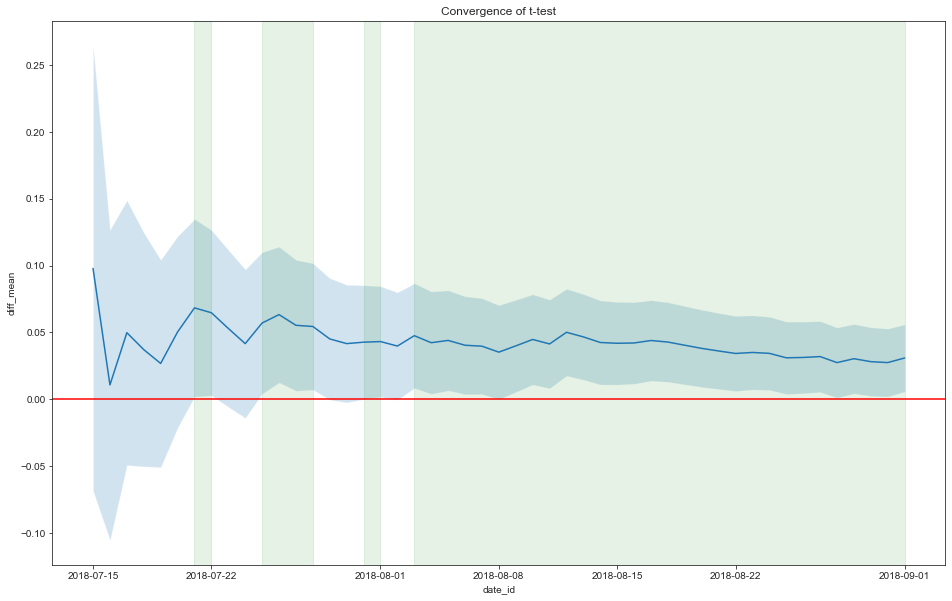

In [66]:
fig, ax = plt.subplots(figsize=(16,10))

sns.lineplot(data=df_cum_exp,
             x="date_id",
             y="diff_mean",
             ax=ax);
ax.set_title("Convergence of t-test");
ax.axhline(0, color="r");
ax.fill_between(x=df_cum_exp["date_id"], 
                y1=df_cum_exp["lc"], 
                y2=df_cum_exp["uc"],
                alpha=0.2);

df_sig = df_cum_exp.assign(sig=df_cum_exp["p-value"].le(.05).astype(int))
df_sig = df_sig[df_sig["sig"].eq(1)]
df_sig = df_sig.assign(shifted_date=df_sig["date_id"].shift(1))
df_sig = df_sig.assign(new_range_ind=(~df_sig["date_id"].eq(df_sig["shifted_date"] + np.timedelta64(1,"D"))).astype(int))
df_sig = (df_sig
          .assign(range_id=df_sig["new_range_ind"].cumsum())
          .drop(columns=["sig",
                         "shifted_date",
                         "new_range_ind"]))
for start_date, end_date in df_sig.groupby("range_id").agg({"date_id": ["min", "max"]}).values:
    ax.axvspan(start_date,
               end_date,
               color="g",
               alpha=0.1);

In [67]:
df_cum_exp

,date_id,diff_mean,se,lc,uc,t-statistic,p-value
0,2018-07-15,0.097950,0.084928,-0.068509,0.264409,-1.153327,0.249097
1,2018-07-16,0.010778,0.059232,-0.105316,0.126872,-0.181964,0.855632
2,2018-07-17,0.049865,0.050535,-0.049184,0.148913,-0.986740,0.323865
3,2018-07-18,0.037196,0.044583,-0.050186,0.124578,-0.834319,0.404162
4,2018-07-19,0.026840,0.039578,-0.050733,0.104412,-0.678153,0.497713
5,2018-07-20,0.050397,0.036563,-0.021265,0.122060,-1.378381,0.168149
6,2018-07-21,0.068419,0.033881,0.002013,0.134825,-2.019415,0.043491
7,2018-07-22,0.064776,0.031558,0.002923,0.126630,-2.052628,0.040149
8,2018-07-23,0.053057,0.029972,-0.005687,0.111802,-1.770239,0.076729
9,2018-07-24,0.041658,0.028346,-0.013900,0.097217,-1.469618,0.141704


In [71]:
df["date_id"].shift(10)

11044          NaT
11045          NaT
11046          NaT
11047          NaT
11048          NaT
           ...    
50636   2018-09-01
50637   2018-09-01
50638   2018-09-01
50639   2018-09-01
50640   2018-09-01
Name: date_id, Length: 39597, dtype: datetime64[ns]